# Analytics Vidhya HR Analytics Challenge

Predict if potential promotee will be promoted or not after the evaluation process.<br>
Version 1: Use LabelEncoder to convert categorical variables. Apply Logistic Regression, Random Forest and XGBoost models.

### Load Data

In [92]:
import pandas as pd
import numpy as np
train_data = pd.read_csv('train_LZdllcl.csv')
test_data = pd.read_csv('test_2umaH9m.csv')

In [93]:
# Check training data only
train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [94]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB


Quite a few columns have the datatype as 'object' which are strings. There are also missing values in the column 'education' and 'previous_year_rating'. We will need to handle column types and missing values in data cleaning.

### Data Cleaning

#### 1. Handling Missing Values

In [95]:
# Get total missing values in 'education' column
train_data.education.isnull().sum()

2409

In [96]:
def fill_missing(df, column, value):
    df_copy = df.copy()
    df_copy[column].fillna(value=value,inplace=True)
    return df_copy

train_data = fill_missing(train_data, "education", "others")
test_data = fill_missing(test_data, "education", "others")

train_data = fill_missing(train_data, "previous_year_rating", 0.0)
test_data = fill_missing(test_data, "previous_year_rating", 0.0)

#### 2. Convert 'object' columns into categorical

In [97]:
train_data.department.value_counts()

Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64

In [98]:
train_data.education.value_counts()

Bachelor's          36669
Master's & above    14925
others               2409
Below Secondary       805
Name: education, dtype: int64

In [99]:
train_data.gender.value_counts()

m    38496
f    16312
Name: gender, dtype: int64

In [100]:
train_data.recruitment_channel.value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

In [101]:
# Convert 'object' columns into categorical datatype

def convert_to_category(df, column_list):
    df_copy = df.copy()
    df_copy[column_list] = df_copy[column_list].apply(lambda x: x.astype('category'))
    return df_copy

train_data = convert_to_category(train_data, ['department','region','education','gender','recruitment_channel'])
test_data = convert_to_category(test_data, ['department','region','education','gender','recruitment_channel'])

#### 3.  Check Duplicate Records

In [102]:
# Check if there is any duplicate employee ID
# Could also use df.duplicated().sum()

condition = bool(train_data.duplicated(subset = 'employee_id').any())

if condition:
    print('There are duplicate employee IDs')
else:
    print('No duplicate employee IDs')

No duplicate employee IDs


### Exploratory Data Analysis

In [103]:
# Check class balance

train_data.is_promoted.value_counts(normalize=True)

0    0.91483
1    0.08517
Name: is_promoted, dtype: float64

The majority classes are 0s with rare 1s, we consider the classes in this dataset are very imbalanced. We will need to use undersampling or oversampling techniques to make training data balanced.

In [104]:
train_data.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.078748,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.496458,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,0.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,2.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


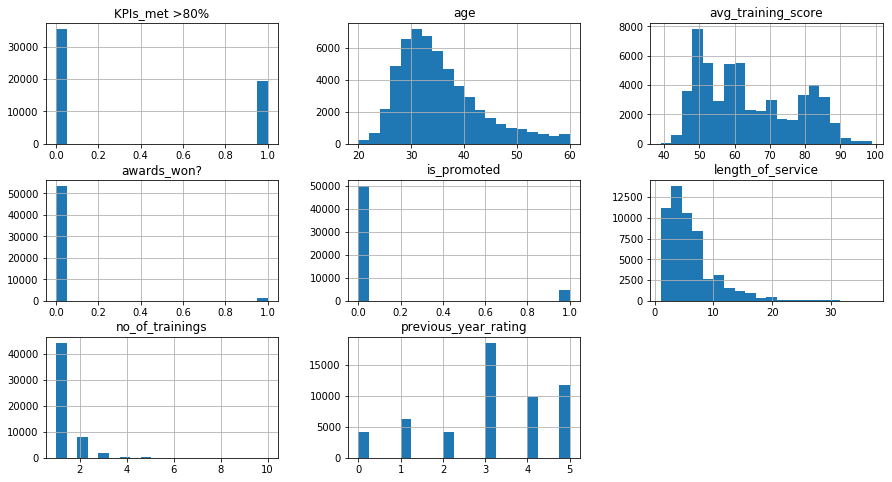

In [105]:
import matplotlib.pyplot as plt

# Remove column 'employee_id' from the dataframe
train_data.drop(columns='employee_id',inplace=True)  
test_data.drop(columns='employee_id',inplace=True)  

# Plot histograms of all numerical columns
train_data.hist(bins=20, figsize=(15,8))
plt.show()

Surprisingly, in 'KPIs_met >80%' feature, more employees did not achieve this goal (0s) than employees who did (1s). There seems to be no outliers.

In [106]:
# Define a function to plot stacked bar chart since there will be multiple stacked bars charts to plot

def create_stacked_bar(column_name):

    promo_by_group = pd.crosstab(index=train_data['is_promoted'],columns = train_data[column_name], normalize = 'columns')
    promo_by_group = promo_by_group.apply(lambda x: round(x,2))
    
    labels = promo_by_group.columns
    list1 = promo_by_group.iloc[0].to_list()
    list2 = promo_by_group.iloc[1].to_list()
    
    list1_name = "Not promoted"
    list2_name = "Promoted"
    title = f"Promotion by {column_name}"
    xlabel = column_name
    ylabel = "Promotion percentage"
    
    fig, ax = plt.subplots(figsize=(10, 5))
    bar_width = 0.5
    
    ax1 = ax.bar(labels,list1, bar_width, label = list1_name)
    ax2 = ax.bar(labels,list2, bar_width, bottom = list1, label = list2_name)

    ax.set_title(title, fontweight = "bold")
    ax.set_xlabel(xlabel, fontweight = "bold")
    ax.set_ylabel(ylabel, fontweight = "bold")
    ax.legend(loc="best")
    
    plt.xticks(list(range(len(labels))), labels,rotation=90)
    plt.yticks(fontsize=9)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f"{h1:.0%}", ha="center", va="center", color="white", fontsize=9, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f"{h2:.0%}", ha="center", va="center", color="white", fontsize=9, fontweight="bold")

    plt.show()


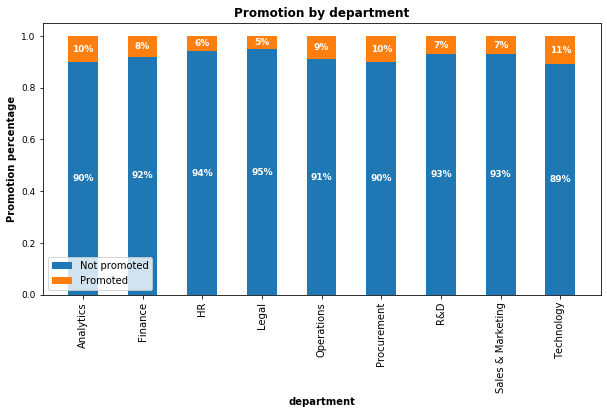

In [107]:
# Plot a stacked bar chart to visualize promotion data by department

create_stacked_bar('department')

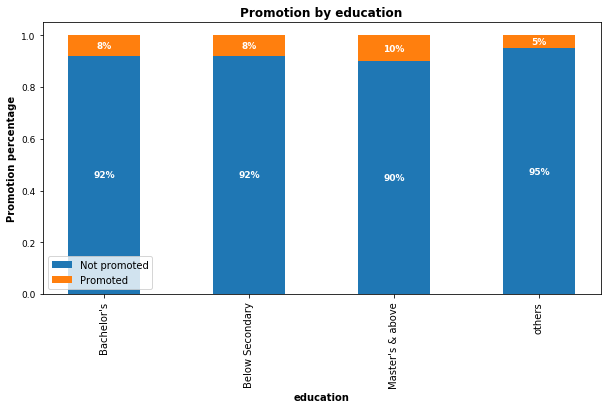

In [108]:
# Plot the percentage of promotion data by education

create_stacked_bar('education')

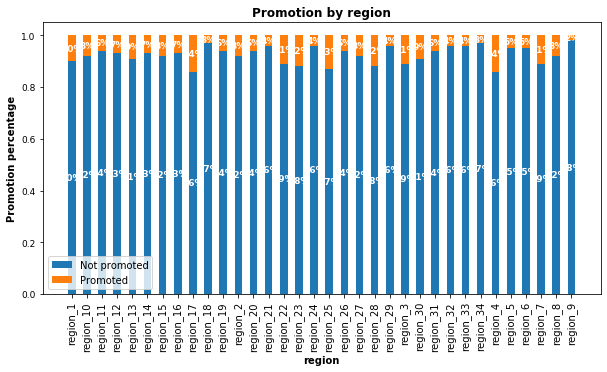

In [109]:
# Plot the percentage of promotion data by region

create_stacked_bar('region')

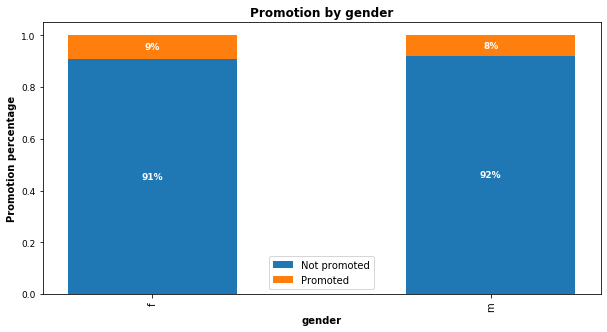

In [110]:
# Plot the percentage of promotion data by gender

create_stacked_bar('gender')

### Modeling Preparation

#### 1.  Feature Engineering

In [21]:
# Bin ‘AGE’ data to groups
# Transform both training data and test data

def convert_age_to_group(df):
    df_copy = df.copy()
    bins = range(20,61,5)    # every 5 years as a bin
    labels = list(range(len(bins)-1))
    df_copy['age_group'] = pd.cut(df_copy['age'],bins=bins, labels=labels, right=True, include_lowest=True)
    df_copy.drop(columns=["age"], inplace=True)
    return df_copy

train_data = convert_age_to_group(train_data)
test_data = convert_age_to_group(test_data)

In [22]:
# Use LabelEncoder to convert categorical features into numerical array

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

def convert_to_numerical(df_train, df_test):
    df_train_copy = df_train.copy()
    df_test_copy = df_test.copy()
    
    for i in ["department", "region", "education", "gender", "recruitment_channel", "age_group"]:
        le = LabelEncoder()
        le.fit(df_train_copy.loc[:, i])
        df_train_copy.loc[:, i] = le.transform(df_train_copy.loc[:, i])
        df_test_copy.loc[:, i] = le.transform(df_test_copy.loc[:, i])
    
    return df_train_copy, df_test_copy

train_data, test_data = convert_to_numerical(train_data, test_data)

#### 2. Feature Selection

In [24]:
# Define predictor variables and target variable
X = train_data.drop(columns=['is_promoted'])
y = train_data['is_promoted']

X_test = test_data.copy()

# Save all feature names as list
feature_cols = X.columns.tolist() 

# Extract numerical columns and save as a list for rescaling
num_cols = ['no_of_trainings', 'previous_year_rating', 'length_of_service',
       'KPIs_met >80%', 'awards_won?', 'avg_training_score']

#### 3. Split Training and Test Data

In [25]:
# Define function to split data with and without SMOTE 

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

def data_split(X, y, imbalance = False):
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3,shuffle=True, stratify=y, random_state=42)
    
    if imbalance:
        # use SMOTE to over sample data
        sm = SMOTE(random_state = 42)
        X_train, y_train = sm.fit_sample(X_train, y_train.ravel())
    
    return X_train, X_validation, y_train, y_validation

#### 4. Rescale Features

In [26]:
# Define function to rescale training data using StandardScaler

from sklearn.preprocessing import StandardScaler

def standard_scaler(X_train, X_validation, X_test,  numerical_cols):
    
    # Make copies of dataset
    X_train_std = X_train.copy()
    X_validation_std = X_validation.copy()
    X_test_std = X_test.copy()
    
    # Apply standardization on numerical features only
    for i in numerical_cols:
        scl = StandardScaler().fit(X_train_std[[i]])     # fit on training data columns
        X_train_std[i] = scl.transform(X_train_std[[i]]) # transform the training data columns
        X_validation_std[i] = scl.transform(X_validation_std[[i]])   # transform the validation data columns
        X_test_std[i] = scl.transform(X_test_std[[i]])   # transform the test data columns

    return X_train_std, X_validation_std, X_test_std

### Predictive Modeling

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import joblib

def run_models(X, y, X_test, num_cols, models):
    
    model_result = []

    for imbalance in [True, False]:
        X_train, X_validation, y_train, y_validation = data_split(X, y, imbalance = imbalance)
        X_train_std, X_validation_std, X_test_std = standard_scaler(X_train, X_validation, X_test, numerical_cols = num_cols)
       
        # Fit the model
        for model_name, model in models.items():
            model.fit(X_train_std, y_train)
            joblib.dump(model, f"{model_name}.pkl")   # save models as pickle file
            scores = cross_val_score(model, X_train_std, y_train, scoring ="roc_auc", cv = 5)
            roc_auc = np.mean(scores)

            model_result.append([model_name, imbalance,  roc_auc]) 
    df = pd.DataFrame(model_result, columns = ["Model", "SMOTE" , "ROC_AUC Score"])  
    df.to_csv("model_initial.csv", index=None)
    
    return df    

In [34]:
# Fit multipe models with and without SMOTE sampling

model_dict = {"Logistic Regression":LogisticRegression(random_state=42), 
              "Random Forest":RandomForestClassifier(random_state=42), 
              "XGBoost":  XGBClassifier(random_state=42)}

run_models(X, y, X_test, num_cols, model_dict)

,Model,SMOTE,ROC_AUC Score
0,Logistic Regression,True,0.792673
1,Random Forest,True,0.989185
2,XGBoost,True,0.978904
3,Logistic Regression,False,0.800802
4,Random Forest,False,0.880352
5,XGBoost,False,0.904373


Based on the above training scores, we will use SMOTE oversampling in tuning hyperparameters.

### Hyperparameters Tuning

#### Logistic Regression

In [29]:
# Randomized search for the best C parameter

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Split data with SMOTE 
X_train, X_validation, y_train, y_validation = data_split(X, y, imbalance = True)

# Rescale data
X_train_std, X_validation_std, X_test_std = standard_scaler(X_train, X_validation, X_test, numerical_cols = num_cols)

# Fit the model
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,random_state=42)
distributions = dict(C=uniform(loc=0, scale=4), penalty=['l2', 'l1'])
lr_best = RandomizedSearchCV(logistic, distributions, random_state=42)

lr_best= lr_best.fit(X_train_std, y_train)   

print(lr_best.best_params_)

{'C': 0.23233444867279784, 'penalty': 'l1'}


In [30]:
# Save tuned model and parameters

joblib.dump(lr_best,"logreg_tuned.pkl") 

['logreg_tuned.pkl']

In [31]:
# Get ROC_AUC score of tuned model on validation data

scores_tuned = cross_val_score(lr_best, X_validation_std, y_validation, scoring = "roc_auc", cv = 5)
roc_auc_lr_best = np.mean(scores_tuned)

# Save best ROC_AUC 
joblib.dump(roc_auc_lr_best,"logreg_ROC_AUC_tuned.pkl") 

print(f'ROC_AUC score after tuning parameters:{roc_auc_lr_best:.3f}')

ROC_AUC score after tuning parameters:0.802


After fine-tuning parameter C, Logistic Regression model's ROC_AUC score on validation data is 0.802.

#### Random Forest

In [35]:
from sklearn.model_selection import GridSearchCV

# Split data with SMOTE 
X_train, X_validation, y_train, y_validation = data_split(X, y, imbalance = True)

# Create parameter grid  
param_grid = {
    'max_depth': [60, 90, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}

# Instantiate the model
clf_rf = RandomForestClassifier(random_state=42)

# Instantiate grid search model
rf_best = GridSearchCV(estimator = clf_rf, param_grid = param_grid,    
                          cv = 3, n_jobs = -1, verbose = 1)

# Fit grid search to the data
rf_best.fit(X_train, y_train)
rf_best.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 18.8min finished


{'max_depth': 60,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [37]:
# Save tuned model and parameters

joblib.dump(rf_best,"clf_rf_tuned.pkl") 

['clf_rf_tuned.pkl']

Tune the model one more time since the best parameters are the minimum or the maximum values provided.

In [38]:
from sklearn.model_selection import GridSearchCV

# Split data with SMOTE 
X_train, X_validation, y_train, y_validation = data_split(X, y, imbalance = True)

# Create parameter grid  
param_grid = {
    'max_depth': [50,60,70],
    'min_samples_leaf': [2,3],
    'min_samples_split': [6,7,8],
    'n_estimators': [200,300,400]
}

# Instantiate the model
clf_rf = RandomForestClassifier(random_state=42)

# Instantiate grid search model
rf_best1 = GridSearchCV(estimator = clf_rf, param_grid = param_grid,    
                          cv = 3, n_jobs = -1, verbose = 1)

# Fit grid search to the data
rf_best1.fit(X_train, y_train)
rf_best1.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 23.9min finished


{'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 400}

In [39]:
# Get ROC_AUC score of tuned model on validation data

scores_tuned = cross_val_score(rf_best1, X_validation, y_validation, scoring = "roc_auc", cv = 5)
roc_auc_rf_best = np.mean(scores_tuned)

# Save best ROC_AUC 
joblib.dump(roc_auc_rf_best,"rf_ROC_AUC_tuned.pkl") 

print(f'ROC_AUC score after tuning parameters:{roc_auc_rf_best:.3f}')

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.4min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.3min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.4min finished


Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  3.3min finished


ROC_AUC score after tuning parameters:0.879


#### XGBoost

In [40]:
from pprint import pprint

# Number of trees
n_estimators = np.arange(200,1000,200)

# Minimum loss reduction required to make a further partition on a leaf node of the tree
# The larger gamma is, the more conservative the algorithm will be
gamma = np.arange(0.1,0.6,0.1)

# Default 0.3, range(0,1)
learning_rate = np.arange(0.1,0.6,0.1)

# Maximum number of levels in tree
max_depth = list(range(3,8,1))

# Subsample ratio of the training instances.Range(0,1)
subsample = np.arange(0.5,0.9,0.1)

# Subsample ratio of columns when constructing each tree. Range(0,1)
colsample_bytree = np.arange(0.5,0.9,0.1)

# Control the balance of positive and negative weights
# Sum(negative instances) / sum(positive instances)
scale_pos_weight = [1,3.5]


# Create the random grid
random_grid_xgb = {'n_estimators': n_estimators,
                   'gamma': gamma,
                   'learning_rate':learning_rate,
                   'max_depth': max_depth,
                   'subsample':subsample,
                   'colsample_bytree':colsample_bytree,
                   'scale_pos_weight':scale_pos_weight
                  }
pprint(random_grid_xgb)

{'colsample_bytree': array([0.5, 0.6, 0.7, 0.8]),
 'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
 'max_depth': [3, 4, 5, 6, 7],
 'n_estimators': array([200, 400, 600, 800]),
 'scale_pos_weight': [1, 3.5],
 'subsample': array([0.5, 0.6, 0.7, 0.8])}


In [41]:
# Split data with SMOTE 
X_train, X_validation, y_train, y_validation = data_split(X, y, imbalance = True)
xgboost = XGBClassifier()

# Use randomized search
xgb_random = RandomizedSearchCV(estimator = xgboost, 
                                param_distributions = random_grid_xgb, 
                                n_iter = 100, 
                                cv = 3, 
                                verbose=1, 
                                random_state=42, 
                                n_jobs = -1,
                                scoring ='roc_auc')


xgb_random.fit(X_train, y_train)   
xgb_random.best_params_, xgb_random.best_score_

print(xgb_random.best_params_,xgb_random.best_score_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 68.3min finished


{'subsample': 0.6, 'scale_pos_weight': 3.5, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.7999999999999999} 0.9867608010031121


In [42]:
# Save tuned model and parameters

joblib.dump(xgb_random,"xgb_tuned.pkl") 

['xgb_tuned.pkl']

In [43]:
# Get ROC_AUC score of tuned model on validation data

scores_tuned = cross_val_score(xgb_random, X_validation, y_validation, scoring = "roc_auc", cv = 5)
roc_auc_xgb_best = np.mean(scores_tuned)

# Save best ROC_AUC 
joblib.dump(roc_auc_xgb_best,"xgb_ROC_AUC_tuned.pkl") 

print(f'ROC_AUC score after tuning parameters:{roc_auc_xgb_best:.3f}')

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.2min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.2min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.9min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.3min finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.6min finished


ROC_AUC score after tuning parameters:0.896


### Model Performance Evaluation

In [65]:
# Define a function to compute Precision, Recall and F1 score

from sklearn.metrics import confusion_matrix

def get_pre_rec_f1(model_name, model,X_validation,y_validation):
    y_pred = model.predict(X_validation)
    tn, fp, fn, tp = confusion_matrix(y_validation, y_pred).ravel()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    return [model_name, precision, recall, F1]

In [70]:
# Logistic Regression model performance on validation data:
col_1 = get_pre_rec_f1("Logistic", lr_best, X_validation_std, y_validation)

# Random Forest model performance on validation data:
col_2 = get_pre_rec_f1("Random Forest",  rf_best1, X_validation, y_validation)

# XGBoost model performance on validation data:
col_3 = get_pre_rec_f1("XGBoost", xgb_random, X_validation, y_validation)

result = []
result.append(col_1)
result.append(col_2)
result.append(col_3)

pd.DataFrame(result, columns = ["Model", "Precision", "Recall", "F1"])

,Model,Precision,Recall,F1
0,Logistic,0.172601,0.657857,0.273456
1,Random Forest,0.392334,0.402143,0.397178
2,XGBoost,0.358912,0.527857,0.427291


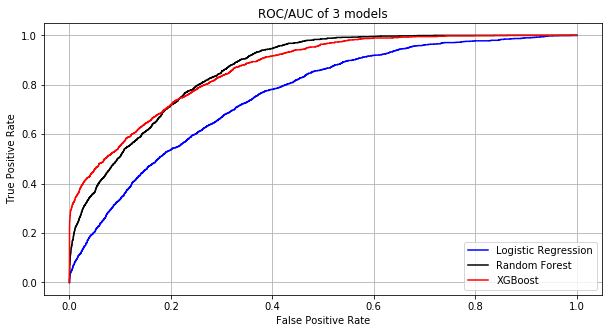

In [51]:
# Plot ROC_AUC curve of 3 models

from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

fig,ax=plt.subplots(figsize=(10,5))

plot_roc_curve(lr_best, X_validation_std, y_validation,ax=ax, color="blue",label='Logistic Regression')
plot_roc_curve(rf_best1, X_validation, y_validation,ax=ax, color="black",label='Random Forest')
plot_roc_curve(xgb_random, X_validation, y_validation,ax=ax, color="red",label='XGBoost')

plt.title('ROC/AUC of 3 models')
plt.grid()

The model with best F1 is XGBoost.

### Model Prediction

In [87]:
# Make prediction using the best model XGBoost

y_prediction = xgb_random.predict(X_test)
result_submission = pd.DataFrame({"employee_id":test_data.employee_id, "is_promoted": y_prediction})
result_submission.to_csv("submission1.csv", index=None)